In [70]:
%run data_loader.py

Data loaded


## Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [71]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.container import Container
import itertools
import math

In [72]:
file_base_name = "data/BBC News {}.csv"
test_data = pd.read_csv(file_base_name.format("Test"))
train_data = pd.read_csv(file_base_name.format("Train"))

In [73]:
print(train_data.info())
print(train_data.describe())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [74]:
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [75]:
solution = pd.read_csv("data/BBC News Sample Solution.csv")
solution.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


In [76]:
# Extracting labels
labels = train_data["Category"].unique().tolist()
labels

['business', 'tech', 'politics', 'sport', 'entertainment']

In [77]:
train_data.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [78]:
def remove_0_tags_for_histograms(ax_container:Container):
    ind = np.where(ax_container.datavalues>0)[0]    
    ax_container.datavalues = ax_container.datavalues[ind]
    ax_container.patches = [ax_container.patches[i] for i in ind]
    return ax_container

def add_histogram_values(ax:plt.Axes):
    [ax.bar_label(remove_0_tags_for_histograms(b)) for b in ax.containers]

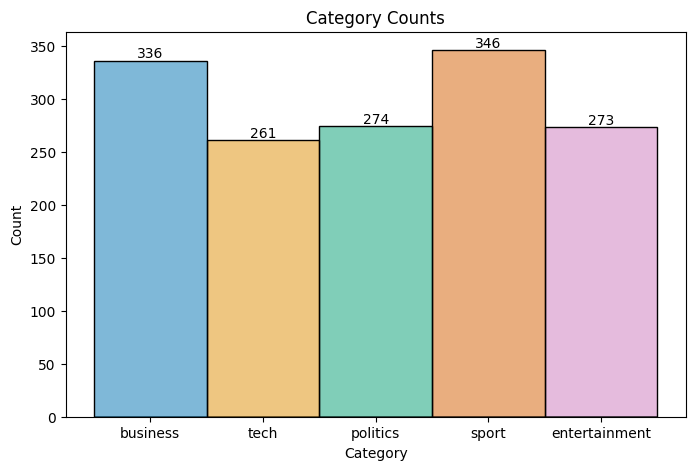

In [79]:
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = train_data,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts')

add_histogram_values(ax)

In [80]:
train_data['text multiplicity'] = train_data.groupby('Text')['Text'].transform('count').astype(str) 


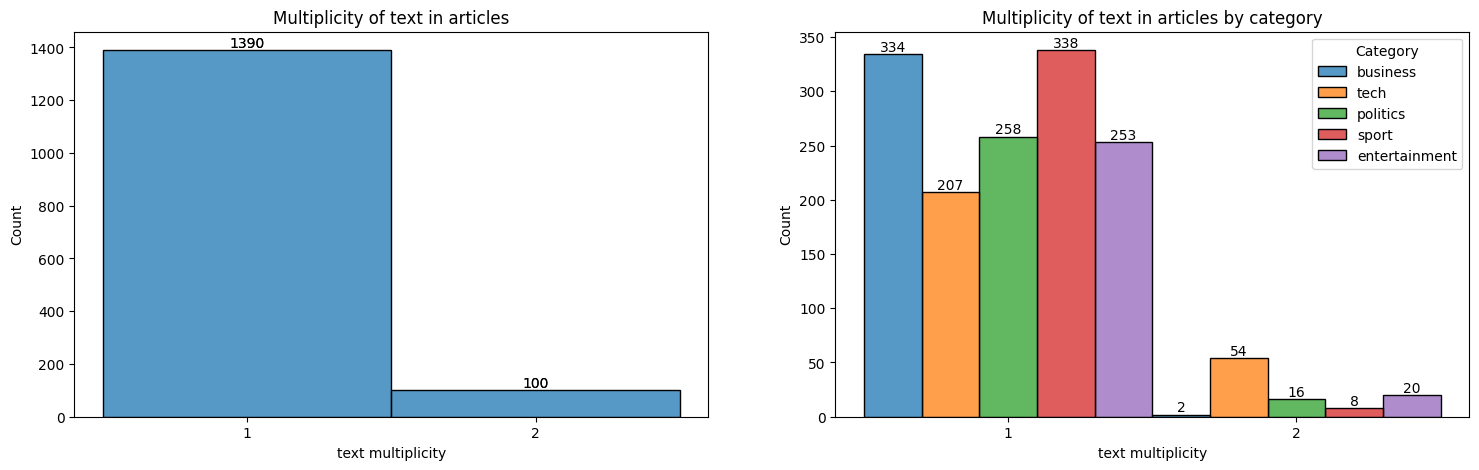

In [81]:
fig, ax = plt.subplots(ncols=2,figsize=(18, 5))

# Histogram showing repeated text multiplicity in training dataframe
ax2 = sns.histplot(
    ax = ax[0],
    data = train_data,
    x='text multiplicity',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles')
add_histogram_values(ax[0])
# Same histogram, by Category
ax2 = sns.histplot(
    ax = ax[1],
    data = train_data,
    x='text multiplicity',
    hue = 'Category',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles by category')
add_histogram_values(ax[0])
add_histogram_values(ax[1])

In [82]:
# Check how many categories are in each repeated text group
print(train_data[train_data['text multiplicity']!='1'].groupby('Text', as_index=False)['Category'].nunique().head())
print("--"*30,"\n")
print('The maximum number of different categories assigned to repeated texts is: {}'.format(\
train_data[train_data['text multiplicity']!='1'].groupby('Text')['Category'].nunique().max()))

                                                Text  Category
0  ask jeeves joins web log market ask jeeves has...         1
1  aviator  creator  in oscars snub the man who s...         1
2  blind student  hears in colour  a blind studen...         1
3  bortolami predicts dour contest italy skipper ...         1
4  britons fed up with net service a survey condu...         1
------------------------------------------------------------ 

The maximum number of different categories assigned to repeated texts is: 1


## Cleaning data

In [83]:
import re

def show_special_words(text:str):
    print("Money format")
    print(re.findall(r'[\$\£\€\¥]\d+(?:\.\d+)?[a-zA-Z]*',text))
    print("Number format")
    print(set(re.findall(r'\s*(\d+(?:[\.\s]\d+)?)(?![%])', text)))
    print("Percentage format")
    print(set(re.findall(r'\b(\d+(?:\.\d+)?%)',text)))
    print("Non alpha-numeric symbols")
    print(set(re.findall(r'[^a-zA-Z0-9 ]', text)))

print('*'*40)
print('Sample text:')
print(train_data['Text'][0])
print('*'*40)
print('Special "words":')
print('-'*40)
show_special_words(train_data['Text'][0])

****************************************
Sample text:
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to 

In [84]:
for i in range(3): show_special_words(train_data["Text"][i])

Money format
['$11bn', '£5.7bn', '$6.75bn']
Number format
{'5.7', '2004', '6.75', '85', '2001', '2002', '11'}
Percentage format
set()
Non alpha-numeric symbols
{')', '£', '-', '(', '.', '$'}
Money format
[]
Number format
{'97.5', '0', '1', '2003', '2004', '95.5'}
Percentage format
{'2%', '10%', '1.6%', '0.2%'}
Non alpha-numeric symbols
{'.', '%', '-'}
Money format
[]
Number format
{'3', '2005', '5', '14', '2.5', '2004', '22 953', '2001', '13', '4', '15', '22', '23 000'}
Percentage format
{'41%', '36%', '34%', '44%', '47%', '48%'}
Non alpha-numeric symbols
{')', ':', '-', '(', '.', '%'}


In [85]:
def normalize_text(text:str):
    text = text.lower()
    text = re.sub(r'[\$\£\€\¥]\d+(?:\.\d+)?[a-zA-Z]*',"money",text)
    text = re.sub(r'\b(\d+(?:\.\d+)?%)'," percentage", text)
    text = re.sub(r'\s*(\d+(?:[\.\s]\d+)?)(?![%])'," number", text)
    text = re.sub(r'[^a-zA-Z0-9 ]',' ', text)
    return text


train_data["Text"] = train_data["Text"].apply(normalize_text)
for i in range(3): show_special_words(train_data["Text"][i])

Money format
[]
Number format
set()
Percentage format
set()
Non alpha-numeric symbols
set()
Money format
[]
Number format
set()
Percentage format
set()
Non alpha-numeric symbols
set()
Money format
[]
Number format
set()
Percentage format
set()
Non alpha-numeric symbols
set()


In [86]:
train_data['word count'] = train_data['Text'].apply(lambda row: len(row.split()))
train_data['char count'] = train_data['Text'].apply(lambda row: len(row))

train_data

,ArticleId,Text,Category,text multiplicity,word count,char count
0,1833,worldcom ex boss launches defence lawyers defe...,business,1,302,1877
1,154,german business confidence slides german busin...,business,1,326,2057
2,1101,bbc poll indicates economic gloom citizens in ...,business,1,514,3204
3,1976,lifestyle governs mobile choice faster bett...,tech,1,633,3663
4,917,enron bosses in money payout eighteen former e...,business,1,353,2204
...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1,230,1326
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,1,561,3148
1487,1590,weak dollar hits reuters revenues at media gro...,business,1,236,1422
1488,1587,apple ipod family expands market apple has exp...,tech,1,560,3299


,ArticleId,word count,char count
count,1490.000000,1490.000000,1490.000000
mean,1119.696644,387.314765,2259.596644
std,641.826283,212.088510,1215.629337
min,2.000000,91.000000,506.000000
25%,565.250000,255.000000,1475.000000
50%,1112.500000,339.000000,1990.000000
75%,1680.750000,471.000000,2778.250000
max,2224.000000,3343.000000,18599.000000


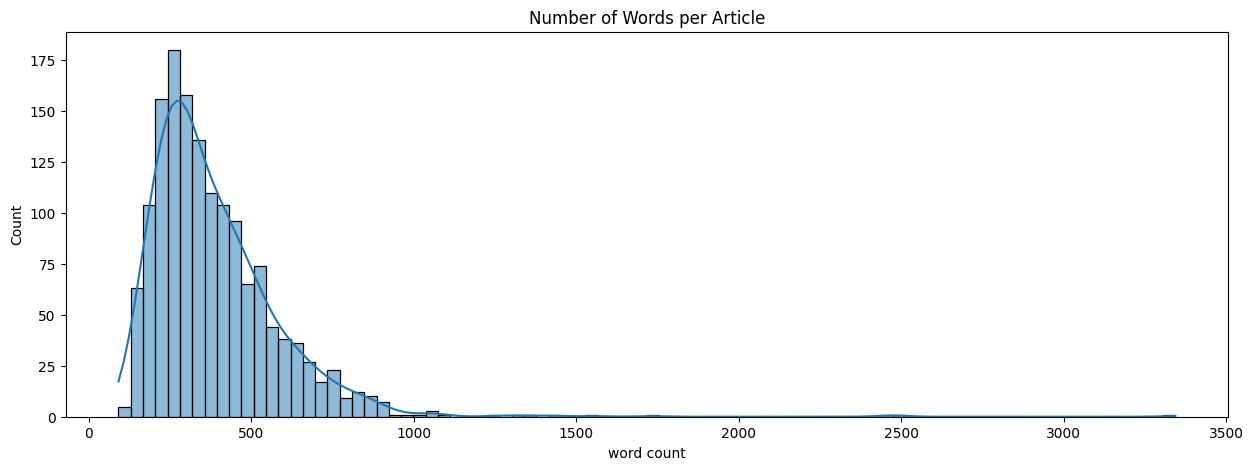

In [87]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data = train_data, 
    x = 'word count',
    kde=True,
    ).set(
        title = 'Number of Words per Article');
train_data.describe()

In [88]:
print('Word count statistics by category:')
word_count_by_category = train_data[['Category','word count']].groupby('Category')
word_count_by_category.describe()

Word count statistics by category:


word count                                                 
                   count        mean         std    min     25%    50%   
Category                                                                 
business           336.0  334.767857  133.028421  143.0  252.75  306.0  \
entertainment      273.0  335.179487  203.386334  143.0  230.00  273.0   
politics           274.0  449.667883  259.737376   91.0  318.25  440.0   
sport              346.0  339.563584  188.491810  118.0  217.00  297.0   
tech               261.0  507.337165  213.385569  186.0  343.00  458.0   

                               
                  75%     max  
Category                       
business       387.50   906.0  
entertainment  383.00  2468.0  
politics       527.75  3343.0  
sport          421.00  1730.0  
tech           646.00  1553.0

[Text(0.5, 1.0, 'Number of words per article by category')]

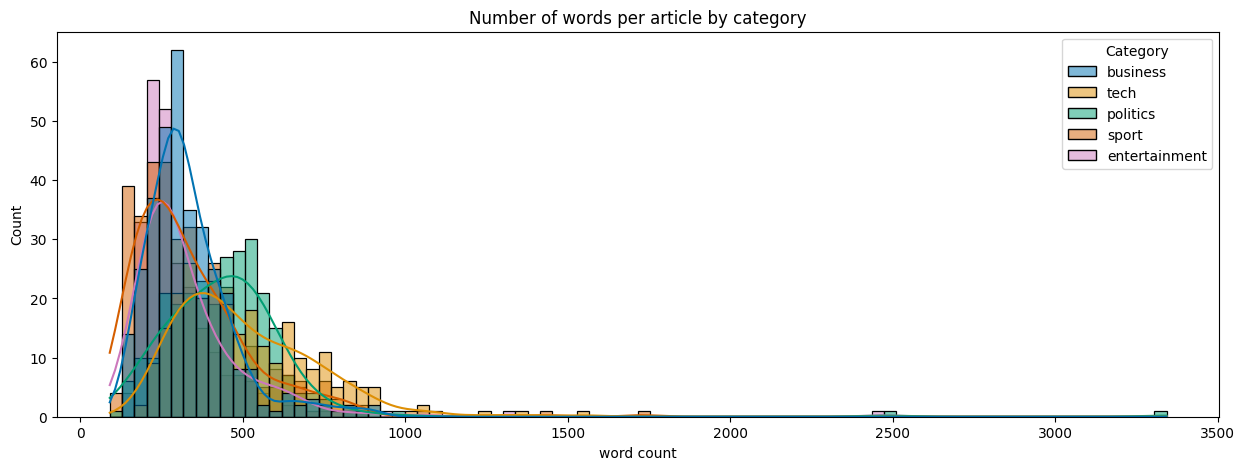

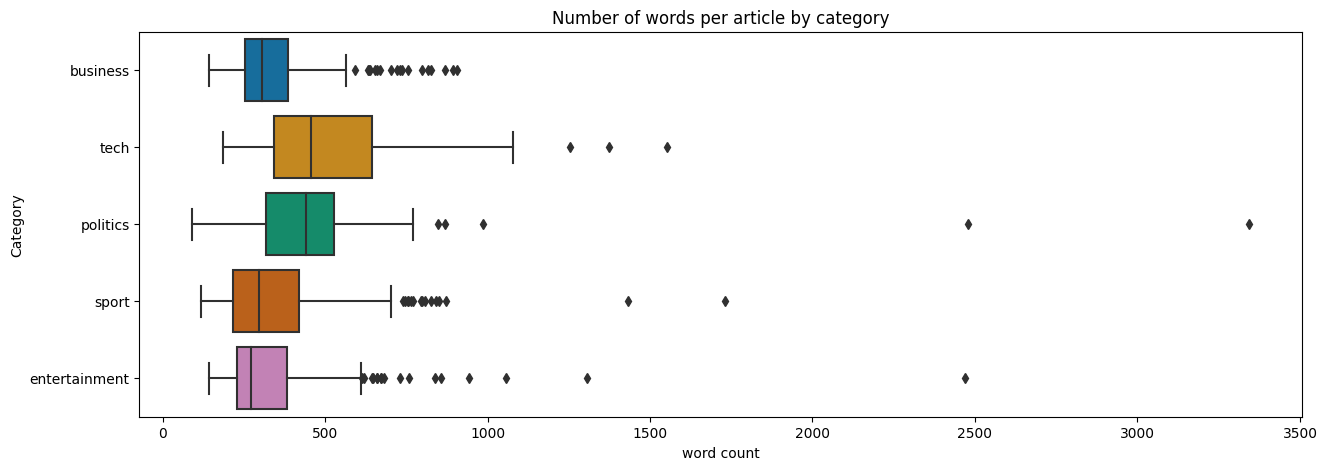

In [89]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data = train_data, 
    x = 'word count',
    palette = 'colorblind',
    kde=True,
    hue = 'Category'
    ).set(
        title = 'Number of words per article by category')

# words per category
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(
    data = train_data, 
    x = 'word count', 
    y = 'Category',
    palette = 'colorblind'
    ).set(
        title = 'Number of words per article by category')

## Processing data

Convert a collection of text documents to a matrix of token counts.

In [90]:
cv=CountVectorizer() 
word_count=cv.fit_transform(train_data['Text'])
print('There are {} documents in the training set.'.format(len(train_data)))
print('There are {} different words in the training set.'.format(word_count.shape[1]))
print('The sparse Matrix WC has size {} and its sparsity is {:.2f}%. '.format(word_count.shape,100*(1-word_count.count_nonzero()/np.prod(word_count.shape))))
print('\nCorresponding DataFrame to WC:')
counts_df = pd.DataFrame(word_count.A,columns=cv.get_feature_names_out())
counts_df

There are 1490 documents in the training set.
There are 23564 different words in the training set.
The sparse Matrix WC has size (1490, 23564) and its sparsity is 99.17%. 

Corresponding DataFrame to WC:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
print('The most popular words amog all documents are are:')
print('\nword  count')
print(counts_df.sum().sort_values().tail())

The most popular words amog all documents are are:

word  count
in     11802
and    12399
of     13003
to     16665
the    35030
dtype: int64


In [92]:
# Include category column into word count
counts_df['_category_']=train_data['Category']

print('Word count by category:')
word_count_by_category = counts_df.groupby('_category_').sum()
word_count_by_category

Word count by category:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
_category_,,,,,,,,,,,,,,,,,,,,,
business,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,2,0,0
entertainment,0,0,0,0,0,4,1,1,0,0,...,0,0,0,0,1,2,0,0,1,0
politics,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sport,0,4,1,3,0,0,0,0,3,0,...,0,0,0,0,0,0,1,5,0,4
tech,0,0,1,0,3,0,0,0,0,2,...,1,1,3,2,0,0,0,0,0,0


In [93]:
is_unique = word_count_by_category.astype(bool).sum(axis=0)==1

total_word_count = word_count_by_category.sum(axis=0)

a = total_word_count[is_unique]
b = word_count_by_category.idxmax(axis=0)[is_unique]
c = cv.get_feature_names_out ()[is_unique]

unique_words =  pd.DataFrame(data=zip(a,b),index=c,columns=['unique word count','Category'])
print('Unique words per category:')
unique_words.groupby('Category').describe()

Unique words per category:


unique word count                                               
                          count      mean       std  min  25%  50%  75%    max
Category                                                                      
business                 2634.0  2.452164  4.736364  1.0  1.0  1.0  2.0  122.0
entertainment            3100.0  2.242903  4.414769  1.0  1.0  1.0  2.0  116.0
politics                 2208.0  2.383605  7.353218  1.0  1.0  1.0  2.0  170.0
sport                    2929.0  3.201434  5.729595  1.0  1.0  1.0  3.0   97.0
tech                     2866.0  2.722261  5.205881  1.0  1.0  1.0  2.0   99.0

In [94]:
C = unique_words.groupby('Category')
U = C.max()
U['top unique word'] = C.idxmax().iloc[:,0]
U

,unique word count,top unique word
Category,,
business,122,yukos
entertainment,116,actress
politics,170,tory
sport,97,roddick
tech,99,spam


In [95]:
print('Top 10 Unique words and their count per category:')
for category,g, in C:
    print('\nCategory: ',category,'\n',g['unique word count'].nlargest(10).to_markdown())  

Top 10 Unique words and their count per category:

Category:  business 
 |            |   unique word count |
|:-----------|--------------------:|
| yukos      |                 122 |
| gm         |                  55 |
| worldcom   |                  54 |
| lse        |                  51 |
| imf        |                  50 |
| ebbers     |                  45 |
| fiat       |                  41 |
| creditors  |                  40 |
| gazprom    |                  40 |
| securities |                  38 |

Category:  entertainment 
 |          |   unique word count |
|:---------|--------------------:|
| actress  |                 116 |
| festival |                 100 |
| aviator  |                  76 |
| oscars   |                  55 |
| foxx     |                  48 |
| sideways |                  40 |
| drake    |                  39 |
| elvis    |                  38 |
| actors   |                  37 |
| staunton |                  35 |

Category:  politics 
 |           

## Step 2: Building and training models

Transform a count matrix to a normalized tf or tf-idf representation [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

$tf$ means term-frequency while $tf-idf$ means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

The goal of using $tf-idf$ instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

The formula that is used to compute the $tf-idf$ for a term $t$ of a document $d$ in a document set is $tf-idf(t, d) = tf(t, d) * idf(t)$, and the $idf$ is computed as $idf(t) = log [\frac{n}{df(t)} ] + 1$ (if smooth_idf=False), where $n$ is the total number of documents in the document set and $df(t)$ is the document frequency of $t$; the document frequency is the number of documents in the document set that contain the term $t$. The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored. (Note that the idf formula above differs from the standard textbook notation that defines the $idf$ as $idf(t) = log [\frac{n}{df(t) + 1}]$).

In [96]:
tfidf_transformer=TfidfTransformer() 
WC2 = tfidf_transformer.fit_transform(word_count)

tfidf_df = pd.DataFrame(WC2.A,columns = cv.get_feature_names_out ())
print('WC2 matrix representation:')
tfidf_df

WC2 matrix representation:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
print('Raking of word scores in WC2:','\n\t\tcolumn sum:')
print(tfidf_df.sum().sort_values())

Raking of word scores in WC2: 
		column sum:
disturb          0.012364
ni               0.012364
stinks           0.012364
consciences      0.012364
tangible         0.012364
                  ...    
in             109.529935
and            109.829587
of             115.481020
to             147.978765
the            313.698197
Length: 23564, dtype: float64


In [98]:
print("Weights given to words by idf:")
pd.DataFrame(tfidf_transformer.idf_, cv.get_feature_names_out(), columns=["idf_weights"]).sort_values(by="idf_weights")

Weights given to words by idf:


,idf_weights
the,1.000000
to,1.004032
of,1.007405
in,1.008081
and,1.010111
...,...
fingertips,7.614055
fingersmith,7.614055
presume,7.614055
presuming,7.614055


In [101]:
print("Subset of the words that are in all categories (universal words):")
is_in_all_cats = word_count_by_category.astype(bool).sum(axis=0)==5
universal_words = pd.DataFrame(word_count.getnnz(axis=0)[is_in_all_cats], # nnz = number of nonzero entries per column (count of articles with word)
                               index=word_count_by_category.columns[is_in_all_cats]._data,
                               columns=['#of Articles with this word'])
universal_words.head()

Subset of the words that are in all categories (universal words):


,#of Articles with this word
ability,64
able,180
about,644
above,40
absolute,16


,#of Articles with this word
count,2155.000000
mean,92.219490
std,168.965734
min,5.000000
25%,21.000000
50%,43.000000
75%,88.000000
max,1490.000000


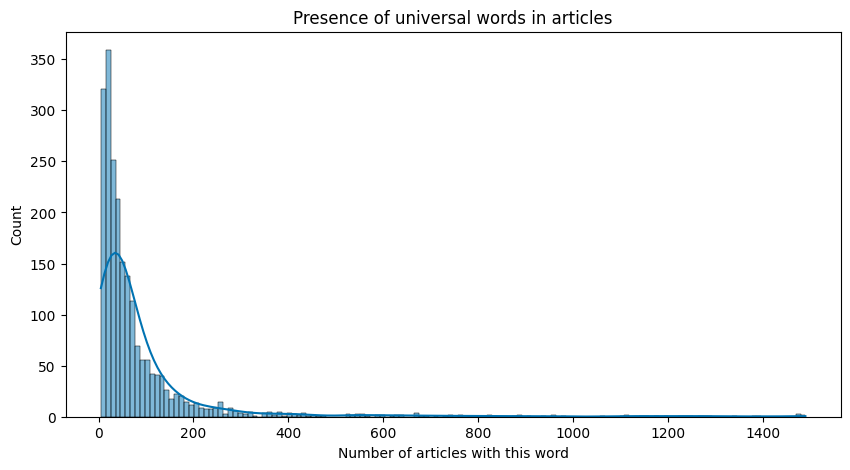

In [100]:
fig, axs = plt.subplots(ncols=1,figsize=(10, 5))
sns.histplot(
    ax=axs,
    data = universal_words, 
    legend = False,
    palette = 'colorblind',
    kde = True,
    ).set(
        title = 'Presence of universal words in articles',
        xlabel='Number of articles with this word');
universal_words.describe()